# 0. Setup

In [1]:
import pandas as pd, numpy as np, requests, json, time, os, pickle
from tqdm import tqdm
from dotenv import load_dotenv
from collections import Counter
from alpaca_api import AlpacaRequester
import matplotlib.pyplot as plt
import matplotlib.dates as mdates   
import ast
import json

tqdm.pandas()

%load_ext autoreload
%autoreload 2

In [2]:
"""
.env structure:

APCA_API_KEY_ID=<your_alpaca_api_key_id>
APCA_API_SECRET_KEY=<your_alpaca_api_secret_key>
"""

load_dotenv()  # by default loads from .env in current dir

True

In [3]:
START = '2020-01-01'
END = '2026-01-01'
AR = AlpacaRequester()

# 1. Getting Data

## 1.1. Getting News Article Headlines

We'll download all news articles from January 1, 2020 to the present

In [4]:
# This will take 2hrs + to run
GET_NEWS = False
if GET_NEWS:
    AR.get_news(start=START,exclude_contentless=False,include_content=False)

Rename for safety

In [5]:
if GET_NEWS:
    os.rename('news/news.csv', 'news/news_final.csv')

## 1.2. Get 1 minute bars for 100 commonly mentioned stocks

In [6]:
BAD_SYMBOLS = ['BTC', 'BTCUSD', 'ETHUSD', 'DOGEUSD', 'SHIBUSD', 'SOLUSD']
OLD_TO_NEW_SYMBOLS = {'FB': 'META'}
def format_symbols(symbols):
    symbols = ast.literal_eval(symbols)
    symbols = [(i.replace('$', '').replace('-', '.') if i not in OLD_TO_NEW_SYMBOLS else OLD_TO_NEW_SYMBOLS[i]) for i in symbols if i not in BAD_SYMBOLS]
    return list(set(symbols))

articles_df = pd.read_csv("news/news_final.csv")
articles_df['symbols'] = articles_df['symbols'].progress_apply(format_symbols)

/var/folders/ck/f9wf3kz948538_qhqyrxj0xc0000gn/T/ipykernel_33510/966622104.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  articles_df = pd.read_csv("news/news_final.csv")
100%|██████████| 1278601/1278601 [00:08<00:00, 159064.68it/s]


In [7]:
symbol_counter = Counter([i for sublist in articles_df['symbols'] for i in sublist])
symbols, _ = zip(*symbol_counter.most_common(100))
symbols = set(symbols)
symbols

{'AAL',
 'AAPL',
 'ABBV',
 'ADBE',
 'AMC',
 'AMD',
 'AMZN',
 'AVGO',
 'AZN',
 'BA',
 'BABA',
 'BAC',
 'BBBY',
 'BIDU',
 'BMY',
 'BNTX',
 'C',
 'CCL',
 'CGC',
 'CMCSA',
 'COIN',
 'COST',
 'CRM',
 'CRWD',
 'CVNA',
 'CVX',
 'DAL',
 'DIS',
 'DKNG',
 'EWU',
 'F',
 'FDX',
 'FXI',
 'GE',
 'GILD',
 'GLD',
 'GM',
 'GME',
 'GOOG',
 'GOOGL',
 'GS',
 'HOOD',
 'INTC',
 'JD',
 'JNJ',
 'JPM',
 'LCID',
 'LI',
 'LLY',
 'LULU',
 'LUV',
 'LYFT',
 'MARA',
 'MCD',
 'META',
 'MRK',
 'MRNA',
 'MS',
 'MSFT',
 'MSTR',
 'MU',
 'NFLX',
 'NIO',
 'NKE',
 'NVAX',
 'NVDA',
 'ORCL',
 'PANW',
 'PFE',
 'PLTR',
 'PTON',
 'PYPL',
 'QCOM',
 'QQQ',
 'RIOT',
 'RIVN',
 'ROKU',
 'RSX',
 'SBUX',
 'SNAP',
 'SNOW',
 'SPOT',
 'SPY',
 'SQ',
 'T',
 'TGT',
 'TLRY',
 'TSLA',
 'TSM',
 'TWTR',
 'UAL',
 'UBER',
 'USO',
 'V',
 'VGK',
 'WFC',
 'WMT',
 'XOM',
 'XPEV',
 'ZM'}

In [8]:
# As of July 2025, this will download about 61.3GB of data

GET_BARS = False
if GET_BARS:
    while True:
        try:
            AR.get_bars(symbols=symbols,start=START,timeframe="1T",adjustment="all")
            break
        except Exception as e:
            to_remove = str(e)[51:-3]
            symbols.remove(to_remove)
            print(f"Removed {to_remove}")

Let's look at an example stock:

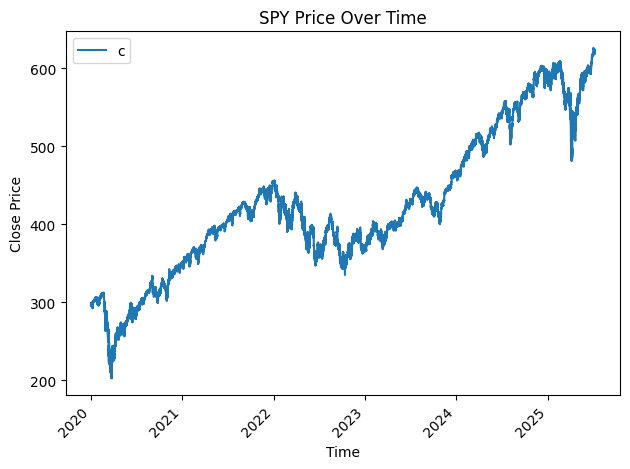

In [17]:
def plot_stock(symbol):
    bars = pd.read_csv(f'bars/{symbol}.csv')

    bars["t"] = pd.to_datetime(bars["t"])
    ax = bars.plot(x="t", y="c", title=f"{symbol} Price Over Time")

    # show only year on x-axis
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax.tick_params(axis="x", rotation=45)

    plt.xlabel("Time")
    plt.ylabel("Close Price")
    plt.tight_layout()
    plt.show()

plot_stock('SPY')

## 1.3. Final cleanup + save to files

In [10]:
symbols = set(symbols)

# Only keep articles that have at least one symbol in the list
articles_df['symbols'] = articles_df['symbols'].apply(lambda x: [i for i in x if i in symbols])
articles_df = articles_df[articles_df['symbols'].apply(len) > 0]
articles_df

,author,content,created_at,headline,id,images,source,summary,symbols,updated_at,url,next_page_token
0,Shomik Sen Bhattacharjee,NaN,2025-07-06T14:31:20Z,Kevin O'Leary Says 'You'll Never Be Free' If Y...,46265862,"[{'size': 'large', 'url': 'https://cdn.benzing...",benzinga,Shark Tank investor Kevin O&#39;Leary says onl...,[TSLA],2025-07-06T14:31:21Z,https://data.alpaca.markets/v1beta1/news?start...,MTc1MTY2NjQyMTAwMDAwMDAwMHw0NjI2MjkyNA==
1,Rounak Jain,NaN,2025-07-06T13:50:47Z,"Cuban's AI Prediction, IBM's Rise, Musk's New ...",46265749,"[{'size': 'large', 'url': 'https://cdn.benzing...",benzinga,"Top stories on AI, including Cuban predicting ...","[AAPL, NVDA]",2025-07-06T13:50:48Z,https://data.alpaca.markets/v1beta1/news?start...,MTc1MTY2NjQyMTAwMDAwMDAwMHw0NjI2MjkyNA==
2,Mohit Manghnani,NaN,2025-07-06T13:44:04Z,"NIKE, Datadog And Snap Are Among Top 11 Large ...",46265728,"[{'size': 'large', 'url': 'https://cdn.benzing...",benzinga,"11 best performing large-cap stocks last week,...","[NKE, AZN, CCL, SNAP]",2025-07-06T13:44:05Z,https://data.alpaca.markets/v1beta1/news?start...,MTc1MTY2NjQyMTAwMDAwMDAwMHw0NjI2MjkyNA==
7,Nabaparna Bhattacharya,NaN,2025-07-06T12:30:35Z,Consumer Tech News (June 30–July 4): Trump's T...,46265552,"[{'size': 'large', 'url': 'https://cdn.benzing...",benzinga,"Trump signs tax bill, markets rally to record ...","[META, BABA, NVDA, GOOGL, LCID, NIO, RIVN, TSL...",2025-07-06T12:30:36Z,https://data.alpaca.markets/v1beta1/news?start...,MTc1MTY2NjQyMTAwMDAwMDAwMHw0NjI2MjkyNA==
8,Rounak Jain,NaN,2025-07-06T12:00:53Z,"iOS 26 Spam Filter, AI Expectations, F1 Succes...",46265493,"[{'size': 'large', 'url': 'https://cdn.benzing...",benzinga,Apple Inc. has been making headlines with new ...,[AAPL],2025-07-06T12:00:54Z,https://data.alpaca.markets/v1beta1/news?start...,MTc1MTY2NjQyMTAwMDAwMDAwMHw0NjI2MjkyNA==
...,...,...,...,...,...,...,...,...,...,...,...,...
1278586,Badar Shaikh,NaN,2025-07-07T07:18:36Z,Tesla's Full Self-Driving Tech Under Fire Agai...,46268433,"[{'size': 'large', 'url': 'https://cdn.benzing...",benzinga,Tesla&#39;s FSD technology once again faces sc...,"[GOOGL, GOOG, TSLA]",2025-07-07T07:18:37Z,https://data.alpaca.markets/v1beta1/news?start...,MTc1MTg2ODk3ODAwMDAwMDAwMHw0NjI2Nzk5NQ==
1278587,Kaustubh Bagalkote,NaN,2025-07-07T07:18:22Z,Steve Jobs Knew The Chip Was The Queen Bee—Kev...,46268432,"[{'size': 'large', 'url': 'https://cdn.benzing...",benzinga,Kevin O&#39;Leary is calling on U.S. policymak...,"[AAPL, NVDA]",2025-07-07T07:18:22Z,https://data.alpaca.markets/v1beta1/news?start...,MTc1MTg2ODk3ODAwMDAwMDAwMHw0NjI2Nzk5NQ==
1278588,Ananya Gairola,NaN,2025-07-07T07:12:57Z,"As Elon Musk's Rift With Donald Trump Deepens,...",46268414,"[{'size': 'large', 'url': 'https://cdn.benzing...",benzinga,Elon Musk&#39;s deepening feud with Donald Tru...,"[GOOGL, GOOG, TSLA]",2025-07-07T07:12:58Z,https://data.alpaca.markets/v1beta1/news?start...,MTc1MTg2ODk3ODAwMDAwMDAwMHw0NjI2Nzk5NQ==
1278594,Shomik Sen Bhattacharjee,NaN,2025-07-07T06:34:44Z,Trump 'Big Beautiful Bill' Sneaks 90% Cap On G...,46268222,"[{'size': 'large', 'url': 'https://cdn.benzing...",benzinga,Gamblers could be hit with a tax bill even if ...,[DKNG],2025-07-07T06:34:45Z,https://data.alpaca.markets/v1beta1/news?start...,MTc1MTg2ODk3ODAwMDAwMDAwMHw0NjI2Nzk5NQ==


In [11]:
articles_df.to_parquet('news/news_cleaned.parquet')
with open('symbols.pkl','wb') as f:
    pickle.dump(symbols,f)

## 1.4. Get stuff

In [12]:
articles_df = pd.read_parquet('news/news_cleaned.parquet')
with open('symbols.pkl','rb') as f:
    symbols = pickle.load(f)

articles_df['symbols'] = articles_df['symbols'].progress_apply(lambda x: [i for i in x if i in symbols])
articles_df.to_parquet('news/news_cleaned_filtered.parquet')

100%|██████████| 278868/278868 [00:00<00:00, 588474.48it/s] 


# 2. Make labels

Now we need to label each headline as to whether or not it caused a significant increase, decrease, or no change in stock price.